<a href="https://colab.research.google.com/github/doxgxxn/YTfinetunedBERT/blob/main/youtube_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
!pip install transformers

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer, BertForSequenceClassification

In [4]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/HuggingFace/data/youtube.csv", engine='python', index_col=0)
data.head()

,id,comment,y
0,@Whydeagle,두번째판은 ㄹㅇ 멱살캐리네여,0
1,@synn3315,카시전 심리전 진짜ㅋㅋㅋ 카시 첫실수하고 조졌다 싶어서 더 대가리박는데 귀신같이 다흘리네,0
2,@user-xe5ol3cs5u,갱플하면서 크리 때문에 한타 대박나는 각 놓치는 아쉬운 경우 ㅈㄴ 많이 나오더라,0
3,@user-JIHO,11:21 이 침착한 일련의 행위가 티어차이를 내는게 아닐까 싶다.. 나였음 만년서...,0
4,@user-dd9nx4mf9h,와 카시 빡세네... 두번째 판은 거의 무쌍이네 ㄷㄷ,0


In [5]:
len(data)

2765

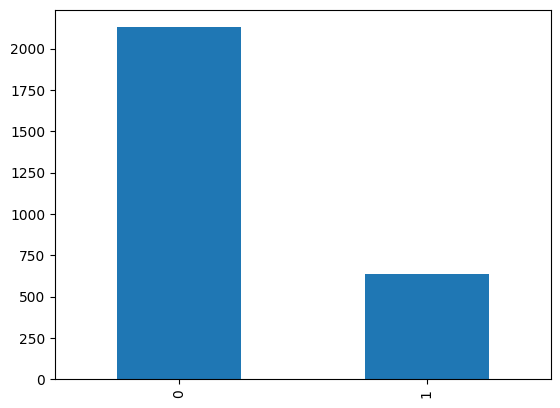

In [6]:
data['y'].value_counts().plot(kind='bar')
plt.show()

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
model = model.to('cuda')

In [9]:
data['comment'][:3].to_list()

['두번째판은 ㄹㅇ 멱살캐리네여',
 '카시전 심리전 진짜ㅋㅋㅋ 카시 첫실수하고 조졌다 싶어서 더 대가리박는데 귀신같이 다흘리네',
 '갱플하면서 크리 때문에 한타 대박나는 각 놓치는 아쉬운 경우 ㅈㄴ 많이 나오더라']

In [10]:
sample_data = [data.loc[0, 'comment'], data.loc[1, 'comment']]
tokenizer(sample_data, padding=True, truncation=True, max_length=512)

{'input_ids': [[101, 9102, 48506, 33323, 10892, 100, 100, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 9786, 14040, 16617, 9491, 12692, 16617, 100, 9786, 14040, 9750, 31503, 15891, 12453, 9678, 32855, 9495, 12965, 12424, 9074, 9069, 11287, 12692, 118963, 41850, 8920, 25387, 118615, 10739, 9056, 119463, 12692, 77884, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [11]:
X = list(data['comment'])
y = list(data['y'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=256)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=256)

In [12]:
X_train_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [13]:
len(X_train), len(X_val)

(2212, 553)

In [14]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = { key :torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [15]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [16]:
train_dataset[2]

{'input_ids': tensor([   101,   1916, 118861,  95977, 119054,  95977, 100329,  95977,  76036,
          95977,  94459,    126,  48506,  56263,  10892,   9706,  17196, 119398,
          56999,  19905,  12424,   9365, 119335,  15001,  35115,  48345,    119,
            102,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]),
 'labels': tensor(1)}

In [17]:
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "recall": recall, "precision" : precision, "f1" : f1}

In [18]:
# Define Trainer

args = TrainingArguments(
    output_dir="/output",
    num_train_epochs= 3,
    per_device_train_batch_size = 8
)

trainer = Trainer(
    model= model,
    args = args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    compute_metrics = compute_metrics
)

In [19]:
trainer.train()

Step,Training Loss
500,0.069500


TrainOutput(global_step=831, training_loss=0.050146827055085295, metrics={'train_runtime': 177.6946, 'train_samples_per_second': 37.345, 'train_steps_per_second': 4.677, 'total_flos': 177328629092160.0, 'train_loss': 0.050146827055085295, 'epoch': 3.0})

In [21]:
trainer.evaluate()

<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 0.019041545689105988,
 'eval_accuracy': 0.9963833634719711,
 'eval_recall': 0.984251968503937,
 'eval_precision': 1.0,
 'eval_f1': 0.9920634920634921,
 'eval_runtime': 2.0575,
 'eval_samples_per_second': 268.776,
 'eval_steps_per_second': 34.022,
 'epoch': 3.0}

In [20]:
model.device

device(type='cuda', index=0)

In [22]:
np.set_printoptions(suppress=True)

In [24]:
text = data['comment'][85:92].to_list()
inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt').to(model.device)
outputs = model(**inputs)

print('first_print :', outputs)

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

print('second_print :', predictions)

predictions = predictions.cpu().detach().numpy()
print('third_print :', predictions)

first_print : SequenceClassifierOutput(loss=None, logits=tensor([[ 3.3683, -3.3468],
        [-4.2643,  4.1584],
        [-4.2528,  4.1602],
        [ 3.4181, -3.3850],
        [ 3.5245, -3.4733],
        [ 2.7575, -2.7904],
        [ 3.5437, -3.4768]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
second_print : tensor([[9.9879e-01, 1.2110e-03],
        [2.1977e-04, 9.9978e-01],
        [2.2192e-04, 9.9978e-01],
        [9.9889e-01, 1.1091e-03],
        [9.9909e-01, 9.1306e-04],
        [9.9612e-01, 3.8805e-03],
        [9.9911e-01, 8.9260e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
third_print : [[0.998789   0.00121096]
 [0.00021977 0.99978024]
 [0.00022192 0.9997781 ]
 [0.99889094 0.00110906]
 [0.999087   0.00091306]
 [0.9961195  0.00388051]
 [0.9991074  0.0008926 ]]


In [26]:
y_pred = np.argmax(outputs.logits.cpu().detach().numpy(), axis=1)
y_pred

array([0, 1, 1, 0, 0, 0, 0])

In [ ]:
trainer.save_model('Youtube')

# Part 2

## **Deploy Finetuned transformers (Bert) Model**
1. Push model to huggingface hub
2. Deploy it on streamlit cloud

In [27]:
!pip install huggingface_hub

In [28]:
from huggingface_hub import notebook_login

notebook_login()

In [29]:
model.push_to_hub('doxgxxn/YoutubeModel')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/doxgxxn/YoutubeModel/commit/c39440c249de709414c648c711a24d2bc5679ccd', commit_message='Upload BertForSequenceClassification', commit_description='', oid='c39440c249de709414c648c711a24d2bc5679ccd', pr_url=None, pr_revision=None, pr_num=None)

In [30]:
model2 = BertForSequenceClassification.from_pretrained("doxgxxn/YoutubeModel")
model2

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/895 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [93]:
text = ["크 자주보는 두 유튜버의대결... 팝콘촵촵", "˚기˚히˚팅˚배˚ 너무 재밌습니다. 잔잔하고 또 뭔가 소소하게 플레이가 근거가있네요","난 고점플레이 보단 이ベ게ベ임드 돈이나버련다…"]
inputs = tokenizer(text, padding=True, truncation=True, max_length=64, return_tensors='pt').to(model.device)
outputs = model(**inputs)

print('first_print :', outputs)

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

print('second_print :', predictions)

predictions = predictions.cpu().detach().numpy()
print('third_print :', predictions)
print('-'*100)

for idx, i in enumerate(text):
    print(f"comment: {text[idx]}\nprobability of spam : {round(predictions[idx][1]* 100, 2)}%")


first_print : SequenceClassifierOutput(loss=None, logits=tensor([[ 3.5114, -3.4636],
        [-4.2586,  4.1647],
        [-4.1799,  4.1269]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
second_print : tensor([[9.9907e-01, 9.3406e-04],
        [2.1965e-04, 9.9978e-01],
        [2.4676e-04, 9.9975e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
third_print : [[0.99906594 0.00093406]
 [0.00021965 0.99978036]
 [0.00024676 0.9997533 ]]
----------------------------------------------------------------------------------------------------
comment: 크 자주보는 두 유튜버의대결... 팝콘촵촵
probability of spam : 0.09%
comment: ˚기˚히˚팅˚배˚ 너무 재밌습니다. 잔잔하고 또 뭔가 소소하게 플레이가 근거가있네요
probability of spam : 99.98%
comment: 난 고점플레이 보단 이ベ게ベ임드 돈이나버련다…
probability of spam : 99.98%


In [44]:
predictions[0]

array([0.00022475, 0.99977523], dtype=float32)

In [34]:
predictions[0][np.argmax(predictions)]

0.99977523